In [1]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [2]:
plt.rcParams["figure.figsize"] = (6,6)

In [3]:
import numpy as np
import pandas as pd

In [4]:
import json

In [5]:
import tqdm
import pathlib

In [6]:
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error

In [7]:
RS = 2734
DATA_DIR = pathlib.Path("../data")

In [8]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_pred-y_true)/y_true))

### Версии:

- `numpy`: 1.16.5
- `pandas`: 0.24.2
- `sklearn`: 0.21.3
- `tensorflow`: 2.0.0

# Загрузка данных

In [10]:
train_data = pd.read_csv(DATA_DIR.joinpath("activity_train.csv.zip"),
                         parse_dates=["date"], index_col="date",
                         compression="zip")
test_data = pd.read_csv(DATA_DIR.joinpath("activity_test.csv.zip"),
                        parse_dates=["date"], index_col="date",
                        compression="zip")
activity_test_target = pd.read_csv(DATA_DIR.joinpath("activity_test_timestamps.csv"),
                                   index_col="date",
                                   parse_dates=["date"])
atactic_test_target = pd.read_csv(DATA_DIR.joinpath("atactic_test_timestamps.csv"),
                                  index_col="date",
                                  parse_dates=["date"])

In [11]:
train_data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f50,f51,f52,f53,f54,f55,activity,atactic_1,atactic_2,atactic_3
date,,,,,,,,,,,,,,,,,,,,,
2018-02-13 08:30:00,49.048771,294.933268,1.675466,0.000051,0.024688,0.001628,1.724180e+06,728860.217994,1.179884,0.513442,...,342.95605,332.80826,332.81665,5493.318081,4829.339027,521.341026,33.998170,NaN,NaN,NaN
2018-02-13 08:31:00,49.007980,294.932866,1.675090,0.000051,0.024659,0.001633,1.724523e+06,729611.819621,1.179814,0.513436,...,342.97174,332.82263,332.78198,5247.641087,5020.168781,520.791888,34.623659,NaN,NaN,NaN
2018-02-13 08:32:00,48.994400,294.932703,1.675766,0.000051,0.024727,0.001639,1.724582e+06,730361.831348,1.179867,0.513290,...,342.97382,332.84164,332.82962,5000.878811,5207.399845,520.242810,33.969483,NaN,NaN,NaN
2018-02-13 08:33:00,48.970760,294.936968,1.675868,0.000051,0.024723,0.001641,1.724677e+06,730486.077321,1.186719,0.511677,...,342.97943,332.88272,332.88680,4751.941204,5387.604237,521.320522,32.701220,NaN,NaN,NaN
2018-02-13 08:34:00,48.952991,294.935404,1.675002,0.000051,0.024708,0.001646,1.724621e+06,730061.574144,1.186838,0.511305,...,342.98720,332.91257,332.90576,4513.198853,5566.278934,522.398114,32.337694,NaN,NaN,NaN


In [12]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 463058 entries, 2018-02-13 08:30:00 to 2018-12-31 22:07:00
Data columns (total 60 columns):
f0           317593 non-null float64
f1           317594 non-null float64
f2           317594 non-null float64
f3           317570 non-null float64
f4           317621 non-null float64
f5           317621 non-null float64
f6           317594 non-null float64
f7           317593 non-null float64
f8           317544 non-null float64
f9           317574 non-null float64
f10          317621 non-null float64
f11          317621 non-null float64
f12          317621 non-null float64
f13          317621 non-null float64
f14          317621 non-null float64
f15          317486 non-null float64
f16          317574 non-null float64
f17          317424 non-null float64
f18          317621 non-null float64
f19          316271 non-null float64
f20          317621 non-null float64
f21          317621 non-null float64
f22          317621 non-null float64
f23 

In [13]:
test_data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55
date,,,,,,,,,,,,,,,,,,,,,
2019-01-01 00:30:00,57.132648,294.708041,1.636037,0.000052,0.019928,0.001852,1.716315e+06,743388.392658,2.989328,0.591614,...,336.59200,336.64236,336.08533,336.16528,343.03546,333.43230,333.38052,522.152305,2178.483009,7568.408012
2019-01-01 00:31:00,57.119122,294.702589,1.635624,0.000052,0.019988,0.001874,1.715817e+06,741369.594337,2.989310,0.591480,...,336.59048,336.64197,336.09860,336.19940,343.03375,333.41724,333.36392,522.445917,1944.569945,7747.926235
2019-01-01 00:32:00,57.079891,294.718029,1.634823,0.000052,0.019912,0.001874,1.716210e+06,743306.512832,2.989467,0.591614,...,336.60050,336.64154,336.26498,336.40747,343.01495,333.37753,333.29938,523.043394,1710.854053,7923.093796
2019-01-01 00:33:00,57.057171,294.718260,1.636119,0.000052,0.019999,0.001885,1.715934e+06,741396.762914,2.989151,0.591434,...,336.62912,336.67390,336.12607,336.23605,342.99408,333.36500,333.30533,523.640990,1476.246953,8097.620964
2019-01-01 00:34:00,57.040150,294.744400,1.635117,0.000052,0.020087,0.001895,1.716098e+06,744469.664631,2.989379,0.591440,...,336.63336,336.69170,336.30340,336.46835,342.97284,333.34850,333.30220,524.238527,1239.382029,8269.639015


In [14]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 103651 entries, 2019-01-01 00:30:00 to 2019-03-14 00:00:00
Data columns (total 56 columns):
f0     87811 non-null float64
f1     87811 non-null float64
f2     87811 non-null float64
f3     87806 non-null float64
f4     87812 non-null float64
f5     87812 non-null float64
f6     87811 non-null float64
f7     87811 non-null float64
f8     87811 non-null float64
f9     87811 non-null float64
f10    87812 non-null float64
f11    87812 non-null float64
f12    87812 non-null float64
f13    87812 non-null float64
f14    87812 non-null float64
f15    87811 non-null float64
f16    87811 non-null float64
f17    87811 non-null float64
f18    87812 non-null float64
f19    87811 non-null float64
f20    87812 non-null float64
f21    87812 non-null float64
f22    87812 non-null float64
f23    87812 non-null float64
f24    87811 non-null float64
f25    87811 non-null float64
f26    87811 non-null float64
f27    87811 non-null float64
f28    87811 no

Объединяем тренировочные и тестовые данные и создаем отдельный датафрейм с целевыми переменными:

In [15]:
data = pd.concat([train_data[test_data.columns], test_data])
train_targets = train_data[["activity", "atactic_1", "atactic_2", "atactic_3"]].copy()

In [16]:
data.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f46,f47,f48,f49,f50,f51,f52,f53,f54,f55
date,,,,,,,,,,,,,,,,,,,,,
2018-02-13 08:30:00,49.048771,294.933268,1.675466,0.000051,0.024688,0.001628,1.724180e+06,728860.217994,1.179884,0.513442,...,335.67578,335.74625,336.91620,336.97977,342.95605,332.80826,332.81665,5493.318081,4829.339027,521.341026
2018-02-13 08:31:00,49.007980,294.932866,1.675090,0.000051,0.024659,0.001633,1.724523e+06,729611.819621,1.179814,0.513436,...,335.66540,335.73734,336.98390,337.02980,342.97174,332.82263,332.78198,5247.641087,5020.168781,520.791888
2018-02-13 08:32:00,48.994400,294.932703,1.675766,0.000051,0.024727,0.001639,1.724582e+06,730361.831348,1.179867,0.513290,...,335.63095,335.70050,336.97913,337.05157,342.97382,332.84164,332.82962,5000.878811,5207.399845,520.242810
2018-02-13 08:33:00,48.970760,294.936968,1.675868,0.000051,0.024723,0.001641,1.724677e+06,730486.077321,1.186719,0.511677,...,335.57654,335.65533,337.00995,337.05280,342.97943,332.88272,332.88680,4751.941204,5387.604237,521.320522
2018-02-13 08:34:00,48.952991,294.935404,1.675002,0.000051,0.024708,0.001646,1.724621e+06,730061.574144,1.186838,0.511305,...,335.53976,335.63748,337.05005,337.10764,342.98720,332.91257,332.90576,4513.198853,5566.278934,522.398114


Убираем проблемные колонки:

In [17]:
data.drop("f28", axis=1, inplace=True)

Text(0.5, 1, 'Activity')

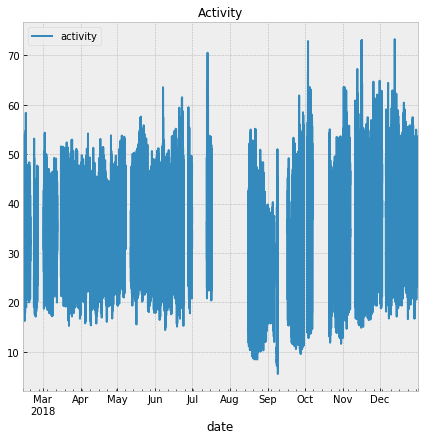

In [18]:
train_targets["activity"].plot()
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

Text(0.5, 1, 'Atactic fraction')

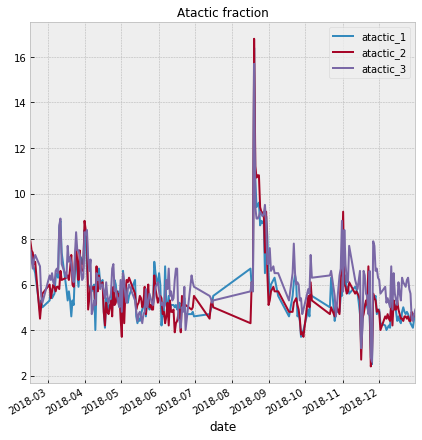

In [19]:
ACOLS = ["atactic_1", "atactic_2", "atactic_3"]

train_targets.loc[train_targets[ACOLS].notnull().all(axis=1), ACOLS].plot()
plt.legend(loc=0)
plt.tight_layout()
plt.title("Atactic fraction", fontsize=12)

# Признаки

In [40]:
PERIODS = ["1H"]
AGGREGATES = ["mean", "median", "std", "max", "min"]

In [41]:
all_features = []

for period in tqdm.tqdm_notebook(PERIODS):
    for agg in AGGREGATES:
        rolling_features = data.rolling(period).aggregate(agg)
        rolling_features.rename(lambda x: "_".join([x, period, agg]), axis=1, inplace=True)
        all_features.append(rolling_features)
all_features = pd.concat(all_features, axis=1)

/Users/b.niatshin/Desktop/Kagle/SIBUR-Challenge/env/lib/python3.6/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [42]:
full_data = data.join(all_features)

In [23]:
activity_data = train_targets[["activity"]].join(full_data.shift(6, freq="H"))
activity_data = activity_data[activity_data.notnull().all(axis=1)]

In [24]:
activity_data.head()

,activity,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f46_6H_min,f47_6H_min,f48_6H_min,f49_6H_min,f50_6H_min,f51_6H_min,f52_6H_min,f53_6H_min,f54_6H_min,f55_6H_min
date,,,,,,,,,,,,,,,,,,,,,
2018-02-13 14:31:00,26.492102,49.007980,294.932866,1.675090,0.000051,0.024659,0.001633,1.724523e+06,729611.819621,1.179814,...,335.66540,335.73734,336.9162,336.97977,342.95605,332.80826,332.78198,5247.641087,4829.339027,520.791888
2018-02-13 14:32:00,34.102710,48.994400,294.932703,1.675766,0.000051,0.024727,0.001639,1.724582e+06,730361.831348,1.179867,...,335.63095,335.70050,336.9162,336.97977,342.95605,332.80826,332.78198,5000.878811,4829.339027,520.242810
2018-02-13 14:33:00,41.518222,48.970760,294.936968,1.675868,0.000051,0.024723,0.001641,1.724677e+06,730486.077321,1.186719,...,335.57654,335.65533,336.9162,336.97977,342.95605,332.80826,332.78198,4751.941204,4829.339027,520.242810
2018-02-13 14:34:00,38.896862,48.952991,294.935404,1.675002,0.000051,0.024708,0.001646,1.724621e+06,730061.574144,1.186838,...,335.53976,335.63748,336.9162,336.97977,342.95605,332.80826,332.78198,4513.198853,4829.339027,520.242810
2018-02-13 14:35:00,42.422569,48.914230,294.937474,1.675524,0.000051,0.024708,0.001647,1.724709e+06,729853.531113,1.186829,...,335.53976,335.62650,336.9162,336.96692,342.95605,332.80826,332.78198,4266.654968,4829.339027,519.448876


In [25]:
tr_data = activity_data[:"2018-10-13"]
cv_data = activity_data["2018-10-14":]

## Тривиальные бенчмарки

In [43]:
print(f"MAPE (last known value, cross-validation set): {100 * mape(cv_data['activity'], tr_data['activity'].iloc[-1]):.2f}%")
print(f"MAPE (median, cross-validation set): {100 * mape(cv_data['activity'], tr_data['activity'].median()):.2f}%")

MAPE (last known value, cross-validation set): 10.99%
MAPE (median, cross-validation set): 13.54%


In [27]:
naive_baseline = activity_test_target.copy()
naive_baseline["rubber"] = tr_data['activity'].iloc[-1]
naive_baseline.to_csv(DATA_DIR.joinpath("activity_naive_baseline.csv"))

## Модель

In [28]:
import random as rn
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import r2_score

In [29]:
rn.seed(RS)
tf.random.set_seed(RS)
np.random.seed(RS)

In [30]:
tf.keras.backend.clear_session()

data_in = keras.Input(shape=(tr_data.shape[1]-1,), name="img_in")

dense_1 = layers.Dense(32, activation="relu")(data_in)
data_out = layers.Dense(1, activation="linear")(dense_1)
model = keras.Model(data_in, data_out)
model.compile(optimizer='adam', loss='mse')

In [31]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
img_in (InputLayer)          [(None, 880)]             0         
_________________________________________________________________
dense (Dense)                (None, 32)                28192     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 28,225
Trainable params: 28,225
Non-trainable params: 0
_________________________________________________________________


In [32]:
EPOCHS = 500
BS = 1024

In [33]:
center, scale = tr_data.iloc[:, 1:].mean().values, tr_data.iloc[:, 1:].std().values
trn = (tr_data.iloc[:, 1:].values - center)/scale
cvn = (cv_data.iloc[:, 1:].values - center)/scale

In [34]:
model.fit(trn, (tr_data[["activity"]].values - tr_data["activity"].mean())/tr_data["activity"].std(),
          epochs=EPOCHS,
          batch_size=BS,
          shuffle=False,
          validation_data=(cvn, (cv_data[["activity"]].values - tr_data["activity"].mean())/tr_data["activity"].std()),
          callbacks=[keras.callbacks.EarlyStopping(patience=5)])

Train on 216400 samples, validate on 84337 samples
Epoch 1/500
216400/216400 [==============================] - 2s 11us/sample - loss: 2.6044 - val_loss: 2.1126
Epoch 2/500
216400/216400 [==============================] - 2s 8us/sample - loss: 2.6238 - val_loss: 8.0508
Epoch 3/500
216400/216400 [==============================] - 1s 7us/sample - loss: 2.1071 - val_loss: 1.8593
Epoch 4/500
216400/216400 [==============================] - 1s 7us/sample - loss: 1.3874 - val_loss: 7.9298
Epoch 5/500
216400/216400 [==============================] - 1s 7us/sample - loss: 1.0788 - val_loss: 0.9722
Epoch 6/500
216400/216400 [==============================] - 2s 8us/sample - loss: 0.9391 - val_loss: 1.2096
Epoch 7/500
216400/216400 [==============================] - 2s 7us/sample - loss: 0.9707 - val_loss: 1.6660
Epoch 8/500
216400/216400 [==============================] - 1s 7us/sample - loss: 0.7771 - val_loss: 0.8601
Epoch 9/500
216400/216400 [==============================] - 2s 7us/sample -

In [35]:
tr_preds = model.predict(trn) * tr_data["activity"].std() + tr_data["activity"].mean()
cv_preds = model.predict(cvn) * tr_data["activity"].std() + tr_data["activity"].mean()

tr_preds = pd.Series(tr_preds.flatten(), index=tr_data.index, name="activity_pred").sort_index()
cv_preds = pd.Series(cv_preds.flatten(), index=cv_data.index, name="activity_pred")

Text(0.5, 1, 'Activity')

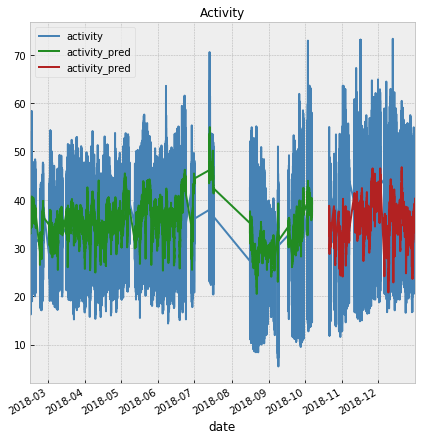

In [36]:
tr_data["activity"].plot(c="steelblue")
cv_data["activity"].plot(c="steelblue", label="")
tr_preds.plot(c="forestgreen")
cv_preds.plot(c="firebrick")
plt.legend(loc=0)
plt.tight_layout()
plt.title("Activity", fontsize=12)

Text(0, 0.5, 'predicted activity')

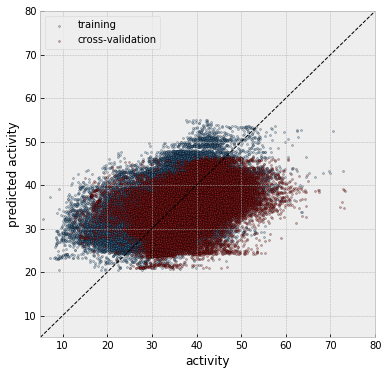

In [37]:
plt.scatter(tr_data["activity"], tr_preds, s=4, alpha=0.4, edgecolor="k", c="steelblue", label="training")
plt.scatter(cv_data["activity"], cv_preds, s=4, alpha=0.4, edgecolor="k", c="firebrick", label="cross-validation")

plt.xlim(5, 80)
plt.ylim(5, 80)
plt.legend(loc=0)
plt.plot([5, 80], [5, 80], "--", c="k", linewidth=1)
plt.xlabel("activity")
plt.ylabel("predicted activity")

In [38]:
print(f"MAPE (training set): {100 * mape(tr_data['activity'].values, tr_preds.values):.2f}%")
print(f"MAPE (cross-validation set): {100 * mape(cv_data['activity'].values, cv_preds.values):.2f}%")

MAPE (training set): 10.69%
MAPE (cross-validation set): 11.90%


Наша модель недостаточно хорошо справляется со слишком большими и слишком маленькими значениями целевой переменной. Подумайте, как это исправить.

In [39]:
test_activity_data = activity_test_target.join(full_data.shift(6, freq="H")).ffill()
ts_preds = model.predict((test_activity_data.values - center)/scale) * tr_data["activity"].std() + tr_data["activity"].mean()

ts_preds = pd.DataFrame(ts_preds, columns=["activity"], index=activity_test_target.index)
ts_preds.loc[activity_test_target.index].to_csv(DATA_DIR.joinpath("activity_nn_baseline.csv"))

# Атактика

В случае атактики у нас есть намного меньше данных. Будем предполагать, что сеть для прогноза активности катализатора строит представление, которые релевантные и для прогноза атактики.

In [44]:
encoder_model = keras.Model(inputs=model.input,
                            outputs=model.get_layer("dense").output)

In [45]:
tr_enc = encoder_model.predict(trn)
cv_enc = encoder_model.predict(cvn)

In [46]:
tr_enc.shape

(216400, 32)

In [47]:
tr_df = pd.DataFrame(tr_enc, columns=[f"enc{i}" for i in range(tr_enc.shape[1])], index=tr_data.index)
cv_df = pd.DataFrame(cv_enc, columns=[f"enc{i}" for i in range(cv_enc.shape[1])], index=cv_data.index)

Признаки уже сдвинуты на 6 часов, поэтому их не нужно сдвигать снова:

In [48]:
atactic_data = train_targets[ACOLS].join(pd.concat([tr_df, cv_df]))

In [49]:
atactic_data = atactic_data[atactic_data.notnull().all(axis=1)]

In [50]:
atactic_data

,atactic_1,atactic_2,atactic_3,enc0,enc1,enc2,enc3,enc4,enc5,enc6,...,enc22,enc23,enc24,enc25,enc26,enc27,enc28,enc29,enc30,enc31
date,,,,,,,,,,,,,,,,,,,,,
2018-02-15 08:00:00,7.3,7.5,7.1,0.990161,0.000000,0.000000,0.948175,0.000000,0.000000,0.000000,...,0.000000,0.000000,3.649993,0.000000,0.000000,0.000000,0.000000,7.796046,0.000000,0.000000
2018-02-16 08:00:00,6.9,7.4,6.7,0.889664,0.650997,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.566377,0.000000,0.000000,0.000000,0.429322,0.687254,4.690067,0.000000,0.000000
2018-02-17 08:00:00,6.7,6.9,7.1,0.000000,1.508423,0.000000,0.000000,1.515740,1.055495,0.000000,...,0.000000,4.662456,0.000000,0.000000,0.000000,0.000000,0.000000,4.835985,1.246298,0.000000
2018-02-18 08:00:00,6.5,7.0,7.3,0.000000,2.128921,0.000000,0.022553,1.402225,1.126332,0.000000,...,0.000000,6.373333,0.403491,0.000000,0.140055,0.000000,1.545846,3.986512,1.340792,0.000000
2018-02-22 08:00:00,4.8,4.5,6.8,7.126855,0.000000,0.000000,0.000000,0.000000,0.000000,1.722018,...,0.000000,0.000000,2.393924,0.000000,0.000000,0.000000,0.892914,0.000000,3.404683,0.568688
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-12-26 08:00:00,4.5,4.4,5.8,0.000000,1.178292,1.845135,0.000000,1.744622,2.771025,2.682396,...,4.144180,1.332838,0.000000,0.000000,1.014006,1.512336,0.000000,2.116887,0.950292,2.968760
2018-12-28 08:00:00,4.2,4.8,4.5,0.000000,0.704745,2.103975,0.000000,1.240486,2.276988,2.720947,...,4.114640,2.444772,0.000000,0.000000,1.129968,2.374661,0.000000,2.931604,1.307115,2.280631
2018-12-29 08:00:00,4.1,4.6,4.4,0.000000,0.680213,1.470107,0.000000,1.010522,4.450551,4.821503,...,2.597952,0.768260,0.000000,0.000000,0.360833,1.013969,0.000000,1.284687,0.053701,0.000000


In [51]:
at_tr_data = atactic_data[:"2018-11-15"]
at_cv_data = atactic_data["2018-11-16":]

## Тривиальные бенчмарки

In [52]:
mapes = []

for cl in ACOLS:
    local_mape = mape(at_cv_data[cl], at_tr_data[cl].iloc[-1])
    mapes.append(local_mape)
    
print(f"MAPE (last known value, cross-validation set): {100 * np.mean(mapes):.2f}%")

mapes = []

for cl in ACOLS:
    local_mape = mape(at_cv_data[cl], at_tr_data[cl].median())
    mapes.append(local_mape)

print(f"MAPE (median, cross-validation set): {100 * np.mean(mapes):.2f}%")

MAPE (last known value, cross-validation set): 18.68%
MAPE (median, cross-validation set): 22.77%


In [53]:
naive_baseline = atactic_test_target.copy()

for cl in ACOLS:
    naive_baseline[cl] = at_tr_data[cl].iloc[-1]
naive_baseline.to_csv(DATA_DIR.joinpath("atactic_naive_baseline.csv"))

## Модели

In [54]:
from sklearn.linear_model import LinearRegression, ARDRegression
from sklearn.ensemble import RandomForestRegressor

In [55]:
tsn = (test_activity_data.values - center)/scale
ts_enc = encoder_model.predict(tsn)
ts_df = pd.DataFrame(ts_enc, columns=[f"enc{i}" for i in range(ts_enc.shape[1])], index=test_activity_data.index)

ts_atactic_data = atactic_test_target.join(ts_df)

Target atactic_1:
	MAPE atactic_1 (training set): 12.77%
	MAPE atactic_1 (cross-validation set): 24.38%


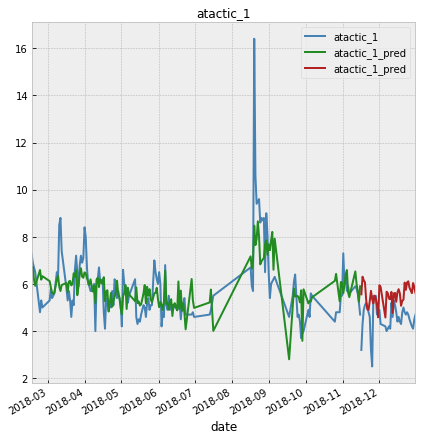

Target atactic_2:
	MAPE atactic_2 (training set): 13.00%
	MAPE atactic_2 (cross-validation set): 22.77%


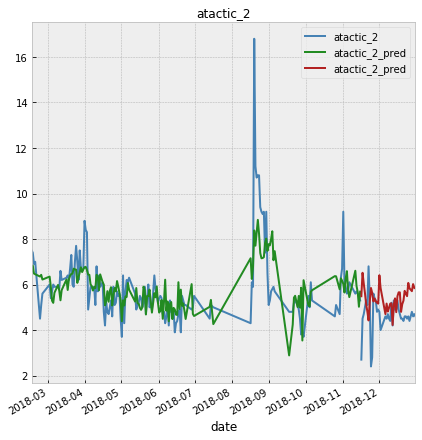

Target atactic_3:
	MAPE atactic_3 (training set): 11.64%
	MAPE atactic_3 (cross-validation set): 22.82%


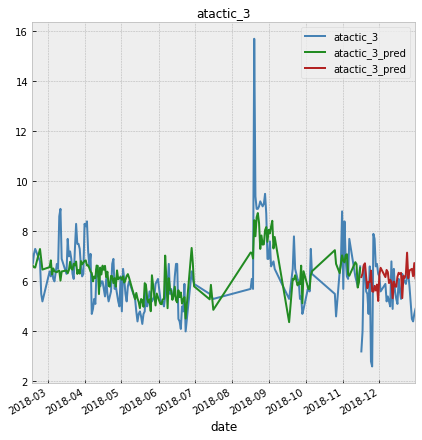

MAPE (training set): 12.47%
MAPE (cross-validation set): 23.32%


In [56]:
tr_mapes = []
cv_mapes = []
ts_preds = atactic_test_target.copy()

for cl in ACOLS:
    model =  ARDRegression()

    model.fit(at_tr_data.iloc[:, 3:], at_tr_data[cl])

    tr_preds = model.predict(at_tr_data.iloc[:, 3:])
    cv_preds = model.predict(at_cv_data.iloc[:, 3:])

    print(f"Target {cl}:")
    print(f"\tMAPE {cl} (training set): {100 * mape(at_tr_data[cl], tr_preds):.2f}%")
    print(f"\tMAPE {cl} (cross-validation set): {100 * mape(at_cv_data[cl], cv_preds):.2f}%")

    tr_mapes.append(mape(at_tr_data[cl], tr_preds))
    cv_mapes.append(mape(at_cv_data[cl], cv_preds))

    tr_preds = pd.Series(tr_preds, index=at_tr_data.index, name=f"{cl}_pred")
    cv_preds = pd.Series(cv_preds, index=at_cv_data.index, name=f"{cl}_pred")

    at_tr_data[cl].plot(c="steelblue")
    at_cv_data[cl].plot(c="steelblue", label="")
    tr_preds.plot(c="forestgreen")
    cv_preds.plot(c="firebrick")
    plt.legend(loc=0)
    plt.tight_layout()
    plt.title(cl, fontsize=12)
    plt.show()

    ts_preds[cl] = model.predict(ts_atactic_data)

print(f"MAPE (training set): {100 * np.mean(tr_mapes):.2f}%")
print(f"MAPE (cross-validation set): {100 * np.mean(cv_mapes):.2f}%")

In [57]:
ts_preds.to_csv(DATA_DIR.joinpath("atactic_nn_baseline.csv"))